# COGS 108 - EDA Checkpoint

# Names

- Naomi Chin
- Leo Friedman
- Jake Heinlein
- Dante Tanjuatco
- Nathan Tripp

<a id='research_question'></a>
# Research Question

*Is the combination of an mlb free agents age and batting performance, measured by batting average and on base plus slugging percentage, indicative of their yearly salary, and if so, can an algorithm predict a players future contract based on these factors?*

# Setup

In [1]:
# import packages and setup visuals
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import patsy
import statsmodels.api as sm
import statistics

# Data Cleaning

Describe your data cleaning steps here.

In [2]:
# merge all contract files in contracts directory as one dataframe
directory = 'data/contracts/'
filepaths = [directory + filename for filename in os.listdir(directory)]
contracts = pd.concat([pd.read_csv(filepath) for filepath in filepaths])
contracts_original = contracts
print('contracts shape: ', contracts.shape)

contracts shape:  (4996, 18)


In [3]:
# set 'Age' column to value in 'Age  7/1/21' column or 'Age 7/1/22' column if NaN
contracts['Age'] = contracts['Age'].add(contracts['Age 7/1/21'], fill_value=0)
contracts['Age'] = contracts['Age'].add(contracts['Age 7/1/22'], fill_value=0)

In [4]:
# drop unecessary columns
contracts = contracts[['Player','Pos\'n', 'Age', 'Term', 'AAV']]

# drop players that are pitchers
contracts = contracts[contracts["Pos'n"].str.contains("hp") == False]

# drop players with NaN values
contracts = contracts.dropna(axis=0)

# drop position column (no longer needed)
contracts = contracts.drop('Pos\'n',axis=1)
display(contracts)

,Player,Age,Term,AAV
0,"Strawberry, Darryl",29.000,1991-96,"$4,050,000"
2,"McGee, Willie",32.000,1991-94,"$3,250,000"
5,"Coleman, Vince",29.000,1991-94,"$2,987,500"
8,"Pendleton, Terry",30.000,1991-94,"$2,550,000"
11,"Bell, George",31.000,1991-93,"$3,266,666"
...,...,...,...,...
140,"Parra, Gerardo",34.055,2022,$1
144,"Pillar, Kevin",33.178,2022,$1
147,"Romine, Austin",33.221,2022,$1
148,"Shaw, Travis",32.076,2022,$1


In [5]:
# functions to standardize variables
def salary_to_int(str_in):
    return int(str_in.replace('$','').replace(',',''))

def term_to_year(str_in):
    return int(str(str_in).split('-')[0])

def standardize_name(str_in):
    if ',' in str_in:
        name_list = str(str_in).split(',')
        str_in = name_list[1].strip() + " " + name_list[0].strip()
    str_in = str_in.replace('Jr.','')
    str_in = str_in.replace('Sr.','')
    str_in = str_in.replace('.','')
    str_in = str_in.replace('é','e')
    str_in = str_in.replace('á','a')
    return str_in.replace(' ', '')

def standardize_age(age):
    return round(float(age), 0)

In [6]:
# standardize salary and term variables
contracts['Player'] = contracts['Player'].apply(standardize_name)
contracts['Age'] = contracts['Age'].apply(standardize_age)
contracts['AAV'] = contracts['AAV'].apply(salary_to_int)
contracts['Term'] = contracts['Term'].apply(term_to_year)
contracts

,Player,Age,Term,AAV
0,DarrylStrawberry,29.0,1991,4050000
2,WillieMcGee,32.0,1991,3250000
5,VinceColeman,29.0,1991,2987500
8,TerryPendleton,30.0,1991,2550000
11,GeorgeBell,31.0,1991,3266666
...,...,...,...,...
140,GerardoParra,34.0,2022,1
144,KevinPillar,33.0,2022,1
147,AustinRomine,33.0,2022,1
148,TravisShaw,32.0,2022,1


In [7]:
# rename columns for consistency
contracts.columns = ['playerName','playerAge','year','yearSalary']
contracts.head()

,playerName,playerAge,year,yearSalary
0,DarrylStrawberry,29.0,1991,4050000
2,WillieMcGee,32.0,1991,3250000
5,VinceColeman,29.0,1991,2987500
8,TerryPendleton,30.0,1991,2550000
11,GeorgeBell,31.0,1991,3266666


In [8]:
# drop contracts that had a yearSalary of $1
contracts = contracts[contracts['yearSalary'] > 1]

In [9]:
# read people and batting files as dataframes
people = pd.read_csv('data/batting/People.csv')
batting = pd.read_csv('data/batting/Batting.csv')
batting_original = batting
print('people shape: ', people.shape)
print('batting shape: ', batting.shape)

people shape:  (20370, 24)
batting shape:  (110495, 22)


In [10]:
batting = batting[['playerID', 'yearID', 'AB', 'H', '2B', '3B', 'HR', 'BB','HBP','SF']]

In [11]:
display(batting[batting['playerID'] == 'abramca01'])
batting = batting.groupby(['playerID', 'yearID']).agg(lambda x: x.sum(min_count=1))
batting = batting.reset_index()
display(batting[batting['playerID'] == 'abramca01'])

,playerID,yearID,AB,H,2B,3B,HR,BB,HBP,SF
33904,abramca01,1949,24,2,1,0,0,7,0.0,NaN
34477,abramca01,1950,44,9,1,0,0,9,0.0,NaN
35053,abramca01,1951,150,42,8,0,3,36,0.0,NaN
35670,abramca01,1952,10,2,0,0,0,2,0.0,NaN
35671,abramca01,1952,158,44,9,2,2,19,0.0,NaN
36303,abramca01,1953,448,128,10,6,15,58,0.0,NaN
36889,abramca01,1954,42,6,1,1,0,10,0.0,0.0
36890,abramca01,1954,423,124,22,7,6,72,4.0,1.0
37466,abramca01,1955,309,75,12,3,6,89,3.0,3.0
38121,abramca01,1956,3,1,0,0,0,2,0.0,0.0


,playerID,yearID,AB,H,2B,3B,HR,BB,HBP,SF
187,abramca01,1949,24,2,1,0,0,7,0.0,NaN
188,abramca01,1950,44,9,1,0,0,9,0.0,NaN
189,abramca01,1951,150,42,8,0,3,36,0.0,NaN
190,abramca01,1952,168,46,9,2,2,21,0.0,NaN
191,abramca01,1953,448,128,10,6,15,58,0.0,NaN
192,abramca01,1954,465,130,23,8,6,82,4.0,1.0
193,abramca01,1955,309,75,12,3,6,89,3.0,3.0
194,abramca01,1956,3,1,0,0,0,2,0.0,0.0


In [12]:
# drop observations with NaN values
batting = batting.dropna(axis=0)

# drop observations with 0 At Bats
batting = batting[batting['AB'] > 0]
batting.shape

(53054, 10)

In [13]:
# functions used for calculating batting average and OBS average
def calc_avg(h, ab):
    return h / ab
    
def calc_obp(h, bb, hbp, ab, sf):
    return (h + bb + hbp) / (ab + bb + sf + hbp)
    
def calc_tb(h, two_b, three_b, hr):
    singles = h - two_b - three_b - hr
    return singles + two_b * 2 + three_b * 3 + hr * 4

def calc_slg(tb, ab):
    return tb / ab

def calc_obs(obp, slg):
    return obp + slg

In [14]:
# create Batting Average column in batting dataframe
avg = calc_avg(h=batting['H'], ab=batting['AB'])
batting['AVG'] = round(avg, 3)

# create On Base Percentage average column in batting dataframe
obp = calc_obp(h=batting['H'], bb=batting['BB'], hbp=batting['HBP'], ab=batting['AB'], sf=batting['SF'])
batting['OBP'] = round(obp, 3)

# create Slugging average column in batting dataframe
tb = calc_tb(h=batting['H'], two_b=batting['2B'], three_b=batting['3B'], hr=batting['HR'])
slg = calc_slg(tb, batting['AB'])
batting['SLG'] = round(slg, 3)

# create On Base Plus Slugging column in batting dataframe
obs = calc_obs(obp, slg)
batting['OBS'] = round(obs, 3)

batting.head()

,playerID,yearID,AB,H,2B,3B,HR,BB,HBP,SF,AVG,OBP,SLG,OBS
1,aardsda01,2006,2,0,0,0,0,0,0.0,0.0,0.000,0.000,0.000,0.000
3,aardsda01,2008,1,0,0,0,0,0,0.0,0.0,0.000,0.000,0.000,0.000
8,aardsda01,2015,1,0,0,0,0,0,0.0,0.0,0.000,0.000,0.000,0.000
9,aaronha01,1954,468,131,27,6,13,28,3.0,4.0,0.280,0.322,0.447,0.769
10,aaronha01,1955,602,189,37,9,27,49,3.0,4.0,0.314,0.366,0.540,0.906


In [15]:
# drop irrelevant columns and rename
batting = batting[['playerID', 'yearID','AB', 'AVG', 'OBP','SLG','OBS']]
batting.columns = ['playerID', 'year', 'AB', 'AVG', 'OBP', 'SLG','OBS']

In [16]:
# add name column to people that combines players first and last name
people['name'] = people['nameFirst'] + ' ' + people['nameLast']

# drop irrelevant columns
people = people[['playerID','name']]

# merge batting and people to add name column to batting dataframe
batting = batting.merge(people, how='left', on='playerID')

# rename and reorder  batting columns for consistency 
batting = batting.rename({'name':'playerName'}, axis=1)
batting = batting[['playerID','playerName','year','AB', 'AVG', 'OBP', 'SLG','OBS']]

# standardize playerName column
batting['playerName'] = batting['playerName'].apply(standardize_name)
batting.head()

,playerID,playerName,year,AB,AVG,OBP,SLG,OBS
0,aardsda01,DavidAardsma,2006,2,0.000,0.000,0.000,0.000
1,aardsda01,DavidAardsma,2008,1,0.000,0.000,0.000,0.000
2,aardsda01,DavidAardsma,2015,1,0.000,0.000,0.000,0.000
3,aaronha01,HankAaron,1954,468,0.280,0.322,0.447,0.769
4,aaronha01,HankAaron,1955,602,0.314,0.366,0.540,0.906


In [17]:
# remove players from batting who are not in contracts
batting = batting[batting['playerName'].isin(list(contracts['playerName'].unique()))]

# NOTE: 22 names in contracts missing from batting; Caused by naming disparities in databases;
print('number of missing names from batting: ', len(contracts['playerName'].unique()) - len(batting['playerName'].unique()))
print('batting: ', batting.shape)
print('cotracts: ', contracts.shape)

number of missing names from batting:  22
batting:  (10254, 8)
cotracts:  (1509, 4)


In [18]:
print(len(contracts['playerName'].unique()))
print(len(batting['playerName'].unique()))

791
769


In [19]:
# all names associated with a unique playerID
names = pd.Series([group[1]['playerName'].reset_index(drop=True)[0] for group in batting.groupby('playerID')])
name_counts = names.value_counts();

# list of players with the same name 
repeated_names = list(name_counts[name_counts > 1].index)

# remove batters and contracts with this name, I wish we didn't have to do this...
batting = batting[~batting['playerName'].isin(repeated_names)]
contracts = contracts[~contracts['playerName'].isin(repeated_names)]

In [20]:
# results of cleaning: 
print('original contracts dataframe: ')
print('\tshape: ', contracts_original.shape)
print('\tunique players: ', len(list(contracts_original['Player'].unique())))

print('new contracts dataframe: ')
print('\tshape: ', contracts.shape)
print('\tunique players: ', len(list(contracts['playerName'].unique())),'\n')

print('original batting dataframe: ')
print('\tshape: ', batting_original.shape)
print('\tunique players: ', len(list(batting_original['playerID'].unique())))

print('new batting dataframe: ')
print('\tshape: ', batting.shape)
print('\tunique players: ', len(list(batting['playerName'].unique())))

original contracts dataframe: 
	shape:  (4996, 18)
	unique players:  2050
new contracts dataframe: 
	shape:  (1421, 4)
	unique players:  753 

original batting dataframe: 
	shape:  (110495, 22)
	unique players:  20166
new batting dataframe: 
	shape:  (9423, 8)
	unique players:  731


# Data Analysis & Results (EDA)

Carry out EDA on your dataset(s); Describe in this section

Yearly salary predictions will depend on the year; factors including inflation and viewership are expected to alter MLB salaries from year to year. First, we will compare the MLB free agent contracts between 1991 and 2022.

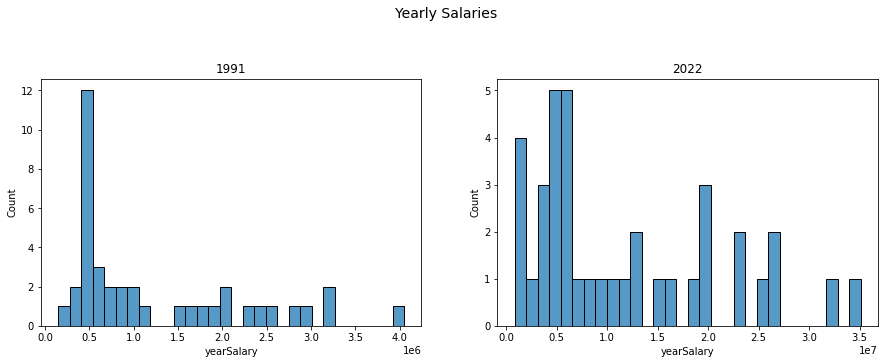

In [21]:
# compare yearly salaries between 1991 and 2022
fig = plt.figure(figsize=(15, 10))
plt.suptitle("Yearly Salaries", fontsize=14)
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax1.title.set_text('1991')
ax2.title.set_text('2022')
sns.histplot(data = contracts[contracts['year'] == 1991], x = 'yearSalary', bins = 30, ax = ax1)
sns.histplot(data = contracts[contracts['year'] == 2022], x = 'yearSalary', bins = 30, ax = ax2)
plt.show()

As expected, the average yearly salary jumped a significant amount from 1991 to 2022. The highest contract from 1991 is around $4,000,000 compared to the hihgest contract from 2022 being close to $35,000,000. 

We will now look at the average salary from each year of data that we have obtained (1991-2022).

C:\Users\naomi\AppData\Local\Temp/ipykernel_12668/1820882526.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  salary_years['avg salary'][i] = statistics.mean(contracts[contracts['year'] == salary_years['year'][i]]['yearSalary'])


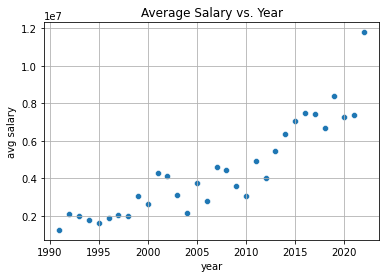

In [22]:
# compare average salaries over the years

salary_years = contracts['year'].value_counts().rename_axis('year').reset_index(name='counts')
salary_years['avg salary'] = ''
for i in range(len(salary_years)):
    salary_years['avg salary'][i] = statistics.mean(contracts[contracts['year'] == salary_years['year'][i]]['yearSalary'])
salary_years = salary_years.sort_values(by=['year']).reset_index(drop = True)
sns.scatterplot(data=salary_years, x='year', y='avg salary').set_title('Average Salary vs. Year')
plt.grid()
plt.show()
# try to fit the data (linear/exponential/etc)

The average salary has a general upward trend as the year increases. From these results, it is important to take into account the year when predicting salaries. 

In order to predict what information and stats are important for predicting salaries, we will take a look at the stats of the highest paid player from each year. Since we want to use previous performace to predict future salaries, we will first look at only the year prior to each contract. It will be helpful to get a better idea of what stats to expect given high salaries. 

In [23]:
# look at the previous year stats for the highest contract from each year

# find the maximum salary from each year
salary_years['max salary'] = ''
for i in range(len(salary_years)):
    salary_years['max salary'][i] = ((contracts[contracts['year'] == salary_years['year'][i]]['yearSalary'])  
    [(contracts[contracts['year'] == salary_years['year'][i]]['yearSalary']).idxmax()])


# find players with max salary
max_player = (contracts[contracts['year']==1991][contracts[contracts['year']==1991]['yearSalary'] ==
 int(salary_years[salary_years['year']==1991]['max salary'])])

for i in range(len(salary_years)-1):
    max_player=max_player.append(contracts[contracts['year']==salary_years['year'][i+1]][contracts[contracts['year']==
    salary_years['year'][i+1]]['yearSalary'] == int(salary_years[salary_years['year']==salary_years['year'][i+1]]['max salary'])])
max_player = max_player.reset_index(drop = True)

# find the previous year stats for each max salary player
max_player['previous AVG'] = ''
max_player['previous AVG'][0] = np.nan
max_player['previous OBP'] = ''
max_player['previous OBP'][0] = np.nan
max_player['previous SLG'] = ''
max_player['previous SLG'][0] = np.nan
max_player['previous OBS'] = ''
max_player['previous OBS'][0] = np.nan
for i in range(len(max_player)-1):
    max_player['previous AVG'][i+1] = (float(batting[batting['year'] == max_player['year'][i]]
    [batting[batting['year'] == max_player['year'][i]]['playerName'] == max_player['playerName'][i]]['AVG']))
for i in range(len(max_player)-1):
    max_player['previous OBP'][i+1] = (float(batting[batting['year'] == max_player['year'][i]]
    [batting[batting['year'] == max_player['year'][i]]['playerName'] == max_player['playerName'][i]]['OBP']))
for i in range(len(max_player)-1):
    max_player['previous SLG'][i+1] = (float(batting[batting['year'] == max_player['year'][i]]
    [batting[batting['year'] == max_player['year'][i]]['playerName'] == max_player['playerName'][i]]['SLG']))
for i in range(len(max_player)-1):
    max_player['previous OBS'][i+1] = (float(batting[batting['year'] == max_player['year'][i]]
    [batting[batting['year'] == max_player['year'][i]]['playerName'] == max_player['playerName'][i]]['OBS']))


# find the minimum salary from each year
salary_years['min salary'] = ''
for i in range(len(salary_years)):
    salary_years['min salary'][i] = ((contracts[contracts['year'] == salary_years['year'][i]]['yearSalary'])  
    [(contracts[contracts['year'] == salary_years['year'][i]]['yearSalary']).idxmin()])


# can look at minimum salary stats similarly to how maximum stats were analyzed


C:\Users\naomi\AppData\Local\Temp/ipykernel_12668/3114184387.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  salary_years['max salary'][i] = ((contracts[contracts['year'] == salary_years['year'][i]]['yearSalary'])
C:\Users\naomi\AppData\Local\Temp/ipykernel_12668/3114184387.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  salary_years['max salary'][i] = ((contracts[contracts['year'] == salary_years['year'][i]]['yearSalary'])
C:\Users\naomi\AppData\Local\Temp/ipykernel_12668/3114184387.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documen

Looking at the average salary, maximum salary, and minimum salary from the first three and last three years of data:

In [24]:
print(salary_years.iloc[np.r_[:3, -3:0]])

    year  counts       avg salary max salary min salary
0   1991      39   1258354.641026    4050000     150000
1   1992      31   2124516.129032   12000000     375000
2   1993      50       1977113.32    7291667     109000
29  2020      44   7292992.431818   35000000    1000000
30  2021      38   7363815.789474   25000000    1000000
31  2022      38  11792543.842105   35100000     850000


The highest salary player from each year along with their previous year stats (AVG, OBP, SLG, OBS):

In [25]:
print(max_player)

          playerName  playerAge  year  yearSalary previous AVG previous OBP  \
0   DarrylStrawberry       29.0  1991     4050000          NaN          NaN   
1     MikePagliarulo       32.0  1992    12000000        0.265        0.361   
2         BarryBonds       28.0  1993     7291667          0.2        0.213   
3     RafaelPalmeiro       29.0  1994     6070000        0.336        0.458   
4        LarryWalker       28.0  1995     5623595        0.319        0.392   
5      RobertoAlomar       28.0  1996     6000000        0.306        0.381   
6        AlbertBelle       30.0  1997    11000000        0.328        0.411   
7    AndresGalarraga       37.0  1998     8250000        0.274        0.332   
8           MoVaughn       31.0  1999    13333333        0.305        0.397   
9         GregVaughn       34.0  2000     8500000        0.281        0.358   
10     AlexRodriguez       25.0  2001    25200000        0.254        0.365   
11        BarryBonds       37.0  2002    18000000   